In [523]:
# 02_RatiosT1.ipynb

In [58]:
import pickle 

with open("/Users/devaldeliwala/mulab/outputs/MCMC/slopes_t1.pkl", "rb") as f: 
    slopes = pickle.load(f) 

In [86]:
slopes['NRCB1']['F115W-F405N_F115W'] = (1.1490425502328, 0.019762732073908294)

In [87]:
fritz_slopes = { 
    "F115W-F212N_F115W": 1.3963332346626527, 
    "F115W-F323N_F115W": 1.2228382161183373, 
    "F115W_F405N_F115W": 1.1194436688421505, 
}

In [88]:
def extinction_ratios_from_slopes(slope_dict):
    """
    Convert CMD slopes  A_filty / E(F115W–<>)  to A_filter / A_F115W
    propagating 1‑sigma errors.
    """ 
    out = {}

    for key, value in slope_dict.items():
        if value is None:
            continue                       
            
        R, sR = value                      
        color, fy = key.split('_')
        f1,  f2 = color.split('-')  

        num = f2 
        r = (R-1.0) / R 
        sr = sR / R**2

        out[f"A{num}/AF115W"] = (r, sr)
    return out

In [89]:
import numpy as np

def relative_to_F212N(out):
    
    # Convert extinction ratios A_lambda/AF115W to A_lambda/AF212N,
    # w/ error propagatoin

    ratios = {
        "AF115W/AF212N": None,
        "AF323N/AF212N": None,
        "AF405N/AF212N": None,
    }

    # AF115W/A212N
    x, dx = out["AF212N/AF115W"]
    val = 1.0 / x
    err = abs(val) * (dx / abs(x))
    ratios["AF115W/AF212N"] = (val, err)

    # AF323N/AF212N
    a, da = out["AF323N/AF115W"]
    b, db = out["AF212N/AF115W"]
    val = a / b
    err = abs(val) * np.sqrt((da / a)**2 + (db / b)**2)
    ratios["AF323N/AF212N"] = (val, err)

    # AF405N/AF212N
    a, da = out["AF405N/AF115W"]
    b, db = out["AF212N/AF115W"]
    val = a / b
    err = abs(val) * np.sqrt((da / a)**2 + (db / b)**2)
    ratios["AF405N/AF212N"] = (val, err)

    return ratios

In [90]:
extinction_ratios = {
    "NRCB1": None,
    "NRCB2": None, 
    "NRCB3": None, 
    "NRCB4": None,
}

for key in ["NRCB1", "NRCB2", "NRCB3", "NRCB4"]: 
    out = extinction_ratios_from_slopes(slopes[key])
    extinction_ratios[key] = relative_to_F212N(out)

extinction_ratios

{'NRCB1': {'AF115W/AF212N': (3.334302520579138, 0.1575918741837599),
  'AF323N/AF212N': (0.530602282154475, 0.26802577690218177),
  'AF405N/AF212N': (0.43249307940257203, 0.0539329606735854)},
 'NRCB2': {'AF115W/AF212N': (3.30617138963295, 0.07822273091074763),
  'AF323N/AF212N': (0.6658924698750658, 0.10725713518825808),
  'AF405N/AF212N': (0.42856163937692915, 0.04151055574333894)},
 'NRCB3': {'AF115W/AF212N': (3.6549299551415535, 0.10762908965540297),
  'AF323N/AF212N': (0.6242210767784461, 0.062341041516560274),
  'AF405N/AF212N': (0.4068284908913007, 0.026615311326074306)},
 'NRCB4': {'AF115W/AF212N': (3.2457446424033, 0.07007142998379014),
  'AF323N/AF212N': (0.5967843755787041, 0.09093262186348695),
  'AF405N/AF212N': (0.4198184293495803, 0.03006355042657992)}}

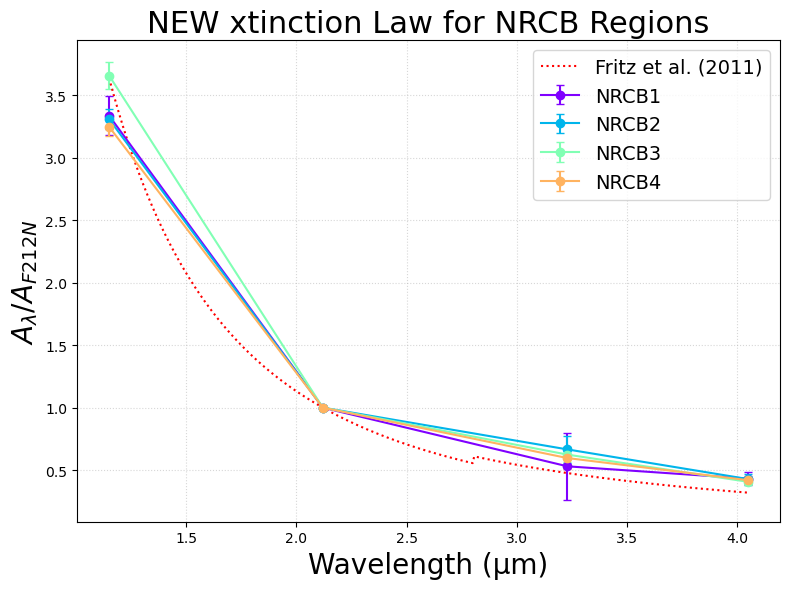

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from cycler import cycler

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)

wavelengths = {
    'F115W': 1.15,
    'F212N': 2.12,
    'F323N': 3.23,
    'F405N': 4.05
}

fig, ax = plt.subplots(figsize=(8,6))
for region, ratios in extinction_ratios.items():
    x = np.array([
        wavelengths['F115W'],
        wavelengths['F212N'],
        wavelengths['F323N'],
        wavelengths['F405N']
    ])
    y = np.array([
        ratios['AF115W/AF212N'][0],
        1.0,
        ratios['AF323N/AF212N'][0],
        ratios['AF405N/AF212N'][0]
    ])
    yerr = np.array([
        ratios['AF115W/AF212N'][1],
        0.0,
        ratios['AF323N/AF212N'][1],
        ratios['AF405N/AF212N'][1]
    ])

    ax.errorbar(x, y, yerr=yerr, fmt='o-', capsize=3, label=region)

# new piecewise extinction law
lambda_ref = np.linspace(1.15, 4.05, 400)

# normalized A(λ) at 2.12 µm
A2p12 = 1.0  # by definition of Aλ/A2.12

# Fritz broken power law 
# \alpha = 2.11 for \lambda \in (1.15, 2.8µm) 
# \alpha = 1.76 for \lambda \in (2.8, 4.05µm) 
pw = np.where(
    lambda_ref < 2.8,
    (lambda_ref/2.12)**(-2.11),
    (lambda_ref/2.12)**(-1.76),
)

ax.plot(lambda_ref, pw, 'r:', lw=1.5, label='Fritz et al. (2011)')

ax.set_xlabel('Wavelength (µm)', fontsize=20)
ax.set_ylabel(r'$A_\lambda / A_{F212N}$', fontsize=20)
ax.set_title('NEW xtinction Law for NRCB Regions', fontsize=22)
ax.legend(loc='upper right', fontsize=14)
ax.grid(alpha=0.5, linestyle=':')

plt.tight_layout()
#plt.savefig("/Users/devaldeliwala/mulab/paper/imgs/extinction_law.png", dpi=300)
plt.show()

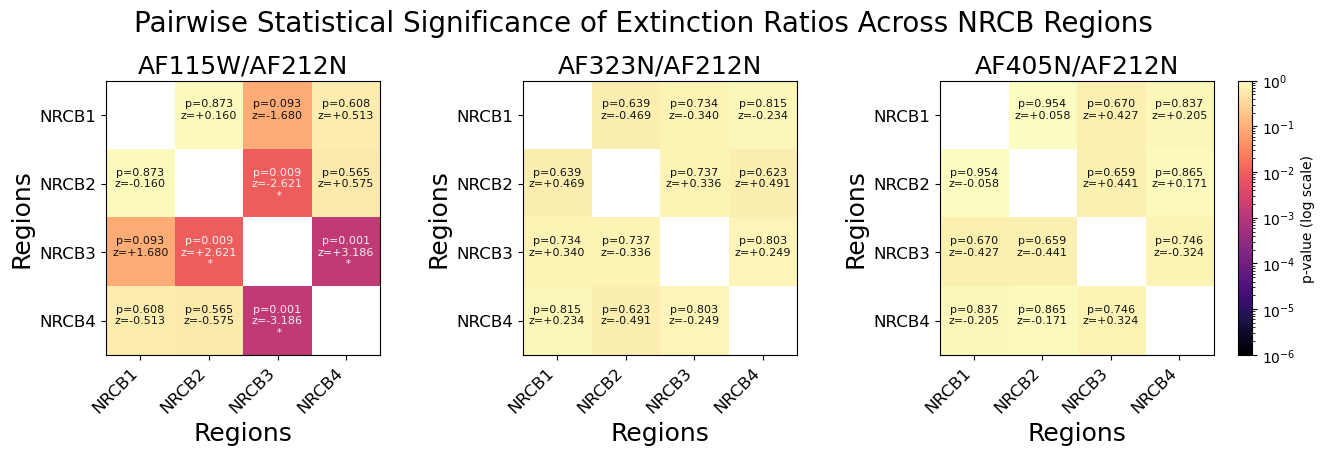

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm

extinction_ratios_ = extinction_ratios
def plot_pairwise_significance(data_dict, *, ratios=None, alpha=0.05):
    """
    Parameters
    ----------
    data_dict : dict
        Outer keys = regions; inner keys = ratio labels;
        values = (mean, σ) tuples.
    ratios : list[str] | None
        Which ratios (inner keys) to plot and in what order.
        Default = the order that appears in the first region.
    alpha : float
        Significance level used for asterisk annotation.
    """
    regions = list(data_dict.keys())
    if ratios is None:
        # Preserve the order that appears in the first region
        ratios = list(next(iter(data_dict.values())).keys())

    n_reg = len(regions)
    n_rat = len(ratios)

    fig, axes = plt.subplots(
        1, n_rat, figsize=(4 * n_rat + 1.5, 4), constrained_layout=True
    )

    # Convenience arrays for text colours
    txt_light = "#f2f2f2"
    txt_dark  = "#111111"

    for ax, ratio in zip(np.ravel(axes), ratios):
        # Build arrays of means and σ for this ratio
        mu   = np.array([data_dict[r][ratio][0] for r in regions])
        sigma = np.array([data_dict[r][ratio][1] for r in regions])

        # Pair‑wise Z‑tests
        Z = (mu[:, None] - mu[None, :]) / np.sqrt(sigma[:, None] ** 2 +
                                                  sigma[None, :] ** 2)
        P = 2.0 * norm.sf(np.abs(Z))        # two‑tailed

        # Diagonal cells are undefined / self‑comparison
        np.fill_diagonal(P, np.nan)
        np.fill_diagonal(Z, np.nan)

        im = ax.imshow(
            P,
            norm=LogNorm(vmin=1e-6, vmax=1),
            cmap="magma",   # any perceptually‑uniform cmap works
        )

        # Annotate each cell
        for i in range(n_reg):
            for j in range(n_reg):
                if i == j:
                    continue
                p_val = P[i, j]
                z_val = Z[i, j]
                star  = " *" if p_val < alpha else ""
                txt   = f"p={p_val:0.3f}\nz={z_val:+0.3f}\n{star}"
                # set text colour for readability on dark/light cells
                ax.text(
                    j,
                    i,
                    txt,
                    ha="center",
                    va="center",
                    fontsize=8,
                    color=txt_light if p_val < 0.01 else txt_dark,
                )

        # Beautify
        ax.set_xticks(range(n_reg), regions, rotation=45, ha="right", fontsize=12)
        ax.set_yticks(range(n_reg), regions, fontsize=12)
        ax.set_title(ratio, fontsize=18)
        ax.set_xlabel("Regions", fontsize=18)
        ax.set_ylabel("Regions", fontsize=18)

    # One shared colour‑bar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1, pad=0.02)
    cbar.set_label("p-value (log scale)")

    fig.suptitle("Pairwise Statistical Significance of Extinction Ratios Across NRCB Regions",
                 fontsize=20, y=1.1)

    fig.savefig("/Users/devaldeliwala/mulab/paper/imgs/stat_significance.png", dpi=300)
    plt.show()
plot_pairwise_significance(extinction_ratios)

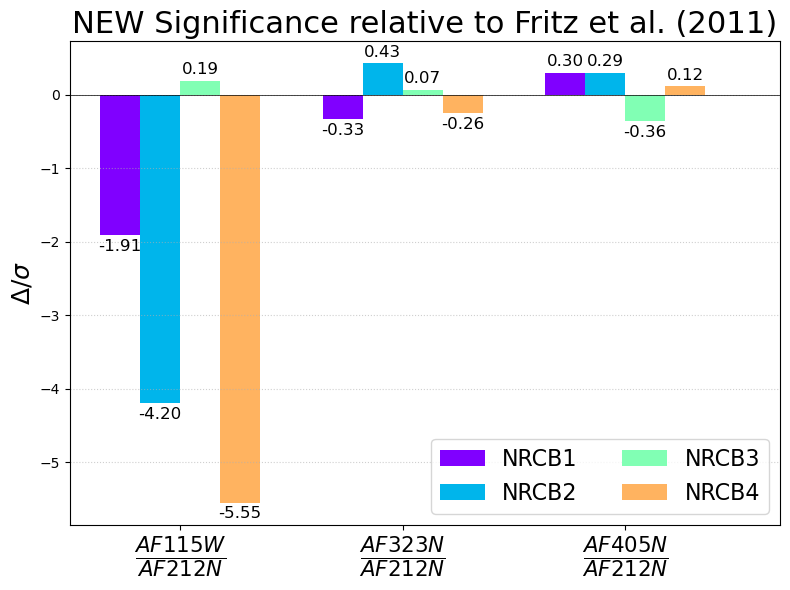

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

fritz_vals =  {
    'AF115W/AF212N': 3.634931436280668,
    'AF212N/AF212N': 1.0,
    'AF323N/AF212N': 0.6199722162731551,
    'AF405N/AF212N': 0.41633970073376225
}

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)

wavelengths = np.array([1.15, 2.12, 3.23, 4.05])
alpha = np.where(wavelengths < 2.8, 2.11, 1.76)
A = wavelengths**(-alpha)
A /= A[wavelengths == 2.12]

regions = list(extinction_ratios.keys())
bands   = ['AF115W/AF212N', 'AF323N/AF212N', 'AF405N/AF212N']
x = np.arange(len(bands))
width = 0.18

fig, ax = plt.subplots(figsize=(8,6))

for i, region in enumerate(regions):
    sigmas = []
    for band in bands:
        meas, err = extinction_ratios[region][band]
        ref       = fritz_vals[band]
        sigmas.append((meas - ref) / err)
    bars = ax.bar(x + (i - 1.5)*width, sigmas, width, label=region)
    
    # annotate each bar
    for bar, sigma in zip(bars, sigmas):
        height = bar.get_height()
        sign = np.sign(height)
        # offset a bit above or below the bar
        y = height + 0.05*sign
        va = 'bottom' if sign >= 0 else 'top'
        ax.text(
            bar.get_x() + bar.get_width()/2,  # x-position: center of bar
            y,                                # y-position: just outside bar
            f"{sigma:.2f}",                   # formatted text
            ha='center', 
            va=va,
            fontsize=12
        )

# horizontal zero line
ax.axhline(0, color='k', lw=0.5)
ax.set_xlim(min(ax.get_xlim()), max(ax.get_xlim())+0.2)
ax.set_xticks(x)

bands   = [r'$\frac{AF115W}{AF212N}$', r'$\frac{AF323N}{AF212N}$', r'$\frac{AF405N}{AF212N}$']
ax.set_xticklabels(bands, fontsize=22)
ax.set_ylabel(r'$\Delta/\sigma$', fontsize=18)
ax.set_title(r'NEW Significance relative to Fritz et al. (2011)', fontsize=22)
ax.legend(ncol=2, fontsize=16)
ax.grid(axis='y', ls=':', alpha=0.6)
plt.tight_layout()
plt.savefig("/Users/devaldeliwala/mulab/paper/imgs/stat_significance_fritz.png", dpi=300)
plt.show()


In [77]:
slopes

{'NRCB1': {'F115W-F212N_F115W': (1.4283934884977552, 0.028921415345827043),
  'F115W-F323N_F115W': (1.18925071763471, 0.11319023750454783),
  'F115W-F405N_F115W': (1.315490425502328, 0.019762732073908294)},
 'NRCB2': {'F115W-F212N_F115W': (1.433619116296105, 0.014707871064684802),
  'F115W-F323N_F115W': (1.252205350310538, 0.05031708658137358),
  'F115W-F405N_F115W': (1.1489297286884714, 0.016071679314645686)},
 'NRCB3': {'F115W-F212N_F115W': (1.37665777135227, 0.015269454835811783),
  'F115W-F323N_F115W': (1.2059653704236974, 0.023703574159578654),
  'F115W-F405N_F115W': (1.1252511645245686, 0.008233544404631395)},
 'NRCB4': {'F115W-F212N_F115W': (1.4452866016546932, 0.013893774181367202),
  'F115W-F323N_F115W': (1.2252900441931094, 0.04163702226129152),
  'F115W-F405N_F115W': (1.148559586379264, 0.011650437046057725)}}